# Modelado del Covid-19 para Guatemala.

El objetivo principal es utilizar data real obtenida del crecimiento del virus COVID-19 en Guatemala, a fin de brindar un panorama aproximado de nuestro caso en el país.

El dataset se obtuvo de la página oficial del MPSAS https://www.mspas.gob.gt/index.php/noticias/covid-19/casos . Se incluye además otro set de datos de https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/L20LOT con el nombre de $country\_confirmed$, para realizar otras pruebas de ajuste o bien, comparar los resultados del modelo. 

El modelo de aproximacion usa $mean\ square$ y fue un modelo obtenido de: https://numbersandshapes.net/post/fitting_sir_to_data_in_python/

El modelo SEIR es un modelo que, agregado al las tres variables conocidas del SIR, agrega una más, los expuestos. Esta variable indica cuantas personas pueden llegar a ser expuestas por el virus y por ende, aumentar el número de contagiados. 

Dicho modelo se describe a continuación:

$\frac{dS}{dt} = -\beta*S*I$

$\frac{dE}{dt} = \beta*S*I - \delta * E$

$\frac{dI}{dt} = \delta*E - \gamma * I$

$\frac{dR}{dt} = \gamma * I$

Finalmente, las estimaciones se hicieron para 1 millón de personas, ya que esto ajusta el modelo de mejor manera. También se muestran los resultados para 17 millones (aproximadamante la población de Guatemala) que da un escenario más real, pero alejado de los datos presentados. 

Esto solo es un modelo ilustrativo, una forma de orientar como se comporta la enfermedad. Hay que tomar en cuenta otros factores si se deseará modelar por completo y con total certeza esta pandemia

## Definición de variables y librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.animation as animation
from datetime import date

In [2]:
datos_gt = [1,1,2,6,6,+
         9,12,17,19,20,21,24,25,28,34,34,36,38,39,47,+
         50,61,61,70,77,87,95,126,137,155,156,167,180,+
         196,214,235,257,289,294,316,384,430,473,500,+
         530,530,557,599,644,688,703,730,763,798,832,900,+
         967,1052,1114,1199,1342,1518,1643,1763,1763,1912,+
         2133,2265,2512,2743,3054,3424,3760,3954,4145,4348,4607,4739,5087,5336,5586,5760,6154,6485,6792]

datos_gt_reales2 = [1,2,3,6,6,8,9,13,17,19,21,21,24,25,28,34,+
                   36,36,39,46,47,50,61,70,74,80,87,126,137,153,+
                   156,167,180,196,214,235,257,289,294,316,342,384,+
                   430,473,500,530,557,585,599,644,688,703,730,763,798,+
                   832,900,967,1052,1114,1199,1342,1518,1643,1763,1912,2001,+
                   2133,2265,2512,2743,3054,3424,3760,3954,4145,4348,4607,4739,+
                   5087,5336,5586,5760,6154,6485,6792,7055,7502,7866,8221,8561,8982,+
                   9491,9845,10272,10706,11251,11868]

datos_gt_reales = [1,2,3,6,6,8,9,13,17,19,21,21,24,25,+
                   28,34,36,36,39,46,47,50,61,70,74,80,87,+
                   126,137,153,156,167,180,196,214,235,257,289,+
                   294,316,342,384,430,473,500,530,557,585,599,644,+
                   688,703,730,763,798,832,900,967,1052,1114,1199,1342,+
                   1518,1643,1763,1912,2001,2133,2265,2512,2743,3054,3424,+
                   3760,3954,4145,4348,4607,4739,5087,5336,5586,5760,6154,6485,+
                   6792,7055,7502,7866,8221,8561,8982,9491,9845,10272,10706,11251,+
                   11868,12509,12755,13145,13769,14540,14819,15828]

datos_gt_reales3 = [1,1,1,3,3,2,1,4,4,2,2,0,3,1,3,6,2,0,+
                   3,7,1,3,11,9,4,3,7,39,11,16,3,11,13,16,+
                   18,21,22,32,5,22,26,42,46,43,27,30,27,28,14,+
                   45,44,15,27,33,35,34,68,67,85,62,85,143,176,125,+
                   120,149,89,132,132,247,231,311,370,336,194,191,203,+
                   259,132,348,249,250,174,394,331,307,263,447,364,355,340,+
                   421,509,354,427,434,545]

datos_gt_fallecidos = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,3,3,+
                       3,3,3,3,5,5,5,5,7,7,7,7,7,8,10,11,11,13,15,15,16,16,16,+
                       16,17,17,19,19,21,23,24,24,26,26,27,29,29,30,33,35,38,43,+
                       45,48,51,55,58,59,63,68,80,90,102,108,116,123,143,158,216,230,+
                       252,267,289,316,334,351,367,384,399,418,432,449,483,514,531,547,582,601,672]

## Función para aproximación del modelo

In [3]:
def sumsq(p,info, N, method):
    size_data = len(info) #obtiene el tama;o de la data, para calcular arrays equivalentes al set.
    
    
    if method == "SEIRD":
        solve = 4
        beta, gamma,delta, mu = p #extrae los parametros iniciales, los que suponen un aproach o aproximacion a los reales
        def SEIRD(t,y): #definiendo nuevamente el modelo SIR para calcular las graficas finales
            S = y[0]
            E = y[1]
            I = y[2]
            R = y[3]
            D = y[4]
            return([-beta*S*I/N, beta*S/N*I-delta*E,delta*E - gamma*I, gamma*I - mu* I, mu*I]) #definicion del modelo, basado en lo descrito anteriormente
        sol = solve_ivp(SEIRD,[0,size_data],[N,0,1,0,0],t_eval=np.arange(0,size_data-0.1,0.2)) #resuelve ecuacion diferencial
        #La funcion solve_ivp es un solver mas potente que odeint por lo que se decide usar este
        
    elif method == "SEIR":
        solve = 2
        beta, gamma,delta = p #extrae los parametros iniciales, los que suponen un aproach o aproximacion a los reales
        def SEIR(t,y): #definiendo nuevamente el modelo SIR para calcular las graficas finales
            S = y[0]
            E = y[1]
            I = y[2]
            R = y[3]
            return([-beta*S*I/N, beta*S*I/N-delta*E,delta*E - gamma*I, gamma*I]) #definicion del modelo, basado en lo descrito anteriormente
        sol = solve_ivp(SEIR,[0,size_data],[N,0,1,0],t_eval=np.arange(0,size_data-0.1,0.2)) #resuelve ecuacion diferencial
        #La funcion solve_ivp es un solver mas potente que odeint por lo que se decide usar este
    else:
        print("Metodo no encontrado")
        return
    return(sum((sol.y[solve][::5]-info)**2)) #retorna la diferencia al cuadrado para minimizar

## Definición de los modelos diferenciales para el cálculo de las curvas. 

In [4]:
def SEIR(t,y,N,params): #definiendo nuevamente el modelo SEIR para calcular las graficas finales
    beta = params[0]
    gamma = params[1]
    delta = params[2]
    S = y[0]
    E = y[1]
    I = y[2]
    R = y[3]
    return([-beta*S*I/N, beta*S*I/N-delta*E,delta*E - gamma*I, gamma*I]) #definicion del modelo, basado en lo descrito anteriormente

In [5]:
def SEIRD(t,y,N,params): #definiendo nuevamente el modelo SIR para calcular las graficas finales
    beta = params[0]
    gamma = params[1]
    delta = params[2]
    mu = params[3]
    S = y[0]
    E = y[1]
    I = y[2]
    R = y[3]
    D = y[4]
    return([-beta*S/N*I, beta*S/N*I-delta*E,delta*E - gamma*I, gamma*I - mu * I, mu*I]) #definicion del modelo, basado en lo descrito anteriormente

# Modelo SEIR

In [ ]:
#Definicion de condiciones iniciales

N_gt_1m = 1e6  #Poblacion Guatemala

I0 = 1 #Un infectado (para mejor aproximacion)
S0 = N_gt_1m - I0 #Los susceptibles son la poblacion menos los que ya han sido infectados
R0 = 0 #No hay recuperados inicialmente
E0 = 0
init = [S0, E0, I0, R0] # array de condiciones iniciales

In [ ]:
method = "SEIR"
msol_gt_1m = minimize(sumsq,[0.4,0.25,5],args=(datos_gt_reales,N_gt_1m,method,),method='Nelder-Mead') #utiliza la aproximacion de miniminizacion para encontrar los parametros reales
msol_gt_1m.x #imprime los parametros ajustados

beta,gamma,delta = msol_gt_1m.x #cargando los nuevos parametros
params_gt_no_control = [beta,gamma,delta]
print(params_gt_no_control)

t_f = 200 #set de tiempo en dias
t_i = 0
sol_gt_1m = solve_ivp(SEIR,[t_i,t_f],init,args=(N_gt_1m,params_gt_no_control),t_eval=np.arange(t_i,t_f-2,0.2))

In [ ]:
fig,ax1 = plt.subplots()

#fig = plt.figure(figsize=(10,4))
ax1.plot(sol_gt_1m.t,sol_gt_1m.y[0],"b-") #S
ax1.tick_params(axis='y')
ax1.legend(["Susceptible"])
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(sol_gt_1m.t,sol_gt_1m.y[3],"r-") #R
ax2.legend(["Recover"])
plt.title("Curvas modelo SEIR - Suscpetibles y recuperados - 1M")
plt.grid()
plt.show()

fig = plt.figure(figsize=(10,4))
plt.plot(sol_gt_1m.t,sol_gt_1m.y[1],"r-") #E
plt.plot(sol_gt_1m.t,sol_gt_1m.y[2],"g-") #I
#plt.legend(["Exposed","Infected"])
plt.title("Curvas modelo SEIR - Expuestos e infectados - 1M")
plt.xlabel('Tiempo (dias)')
plt.axvline(x=106, color='k', linestyle='--')
plt.legend(["Expuestos","Infectados","Día Actual"])
plt.grid()
plt.savefig('Curva_EI_1M.png')

In [ ]:
beta,gamma,delta = msol_gt_1m.x #cargando los nuevos parametros
params = [beta,gamma,delta]

t_f = 110 #set de tiempo en dias
t_i = 0
sol_gt_1m = solve_ivp(SEIR,[t_i,t_f],init,args=(N_gt_1m,params),t_eval=np.arange(t_i,t_f-2,0.2))

S = sol_gt_1m.y[0]
E = sol_gt_1m.y[1]
I = sol_gt_1m.y[2]
R = sol_gt_1m.y[3]
time = sol_gt_1m.t

size = np.arange(0,len(datos_gt_reales),1)
size2 = np.arange(0,len(datos_gt),1)

f_date = date(2020, 3, 13)
l_date = date(2020, 6, 18)
delta = l_date - f_date

fig = plt.figure(figsize=(10,4))
plt.bar(size,datos_gt_reales) #R
#plt.bar(size2,datos_gt) #R
plt.plot(time,I,"r-") #I
#plt.plot(time,S+E+I+R)
plt.title("Comparacion entre el modelo y los datos - 1M")
plt.xlabel('Tiempo (dias)')
plt.axvline(x=106, color='k', linestyle='--')
plt.legend(["Modelo","Día Actual","Datos MSPAS"])
plt.grid()
plt.savefig('Casos_1m.png')

## Modelo SEIR con 17 millones (población total)

In [ ]:
#Definicion de condiciones iniciales

N_gt = 17e6  #Poblacion Guatemala

I0 = 1 #Un infectado (para mejor aproximacion)
S0 = N_gt - I0 #Los susceptibles son la poblacion menos los que ya han sido infectados
R0 = 0 #No hay recuperados inicialmente
E0 = 0
init = [S0, E0, I0, R0] # array de condiciones iniciales

In [ ]:
method = "SEIR"
msol_gt = minimize(sumsq,[0.8,0.5,5],args=(datos_gt_reales,N_gt,method,),method='Nelder-Mead') #utiliza la aproximacion de miniminizacion para encontrar los parametros reales
msol_gt.x #imprime los parametros ajustados

beta,gamma,delta = msol_gt.x #cargando los nuevos parametros
params_gt_no_control = [beta,gamma,delta]
print(params_gt_no_control)

t_f = 220 #set de tiempo en dias
t_i = 0
sol_gt = solve_ivp(SEIR,[t_i,t_f],init,args=(N_gt,params_gt_no_control),t_eval=np.arange(t_i,t_f-2,0.2))

In [ ]:
fig,ax1 = plt.subplots()

#fig = plt.figure(figsize=(10,4))
ax1.plot(sol_gt.t,sol_gt.y[0],"b-") #S
ax1.tick_params(axis='y')
ax1.legend(["Susceptible"])
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(sol_gt.t,sol_gt.y[3],"r-") #R
ax2.legend(["Recover"])
plt.title("Curvas modelo SEIR")
plt.grid()
plt.show()

fig = plt.figure(figsize=(10,4))
plt.plot(sol_gt.t,sol_gt.y[1],"r-") #E
plt.plot(sol_gt.t,sol_gt.y[2],"g-") #I
#plt.legend(["Exposed","Infected"])
plt.title("Curvas modelo SEIR - Expuestos e infectados - 17M")
plt.xlabel('Tiempo (dias)')
plt.axvline(x=106, color='k', linestyle='--')
plt.legend(["Expuestos","Infectados","Día Actual"])
plt.grid()
plt.savefig('Curva_EI_17M.png')

In [ ]:
beta,gamma,delta = msol_gt.x #cargando los nuevos parametros
params = [beta,gamma,delta]

t_f = 110 #set de tiempo en dias
t_i = 0
sol_gt = solve_ivp(SEIR,[t_i,t_f],init,args=(N_gt,params),t_eval=np.arange(t_i,t_f-2,0.2))

S = sol_gt.y[0]
E = sol_gt.y[1]
I = sol_gt.y[2]
R = sol_gt.y[3]
time = sol_gt.t

size = np.arange(0,len(datos_gt_reales),1)
size2 = np.arange(0,len(datos_gt),1)

f_date = date(2020, 3, 13)
l_date = date(2020, 6, 18)
delta = l_date - f_date

fig = plt.figure(figsize=(10,4))
plt.bar(size,datos_gt_reales) #R
#plt.bar(size2,datos_gt) #R
plt.plot(time,I,"r-") #I
#plt.plot(time,S+E+I+R)
plt.title("Comparacion entre el modelo y los datos - 17M")
plt.xlabel('Tiempo (dias)')
plt.axvline(x=97, color='k', linestyle='--')
plt.legend(["Modelo","Día Actual","Datos MSPAS"])
plt.grid()
plt.savefig('Casos_17m.png')

In [ ]:
f_date = date(2020, 3, 13)
l_date = date(2020, 6, 27)
delta = l_date - f_date
print (delta)

# Modelo SEIRD

In [12]:
#Definicion de condiciones iniciales

N_gt = 1e6  #Poblacion Guatemala

I0 = 1 #Un infectado (para mejor aproximacion)
S0 = N_gt - I0 #Los susceptibles son la poblacion menos los que ya han sido infectados
R0 = 0 #No hay recuperados inicialmente
E0 = 0
D0 = 0
init = [S0, E0, I0, R0, D0] # array de condiciones iniciales

In [18]:
method = "SEIRD"
#datos_gt_reales
#datos_gt_fallecidos
msol_gt = minimize(sumsq,[4.5,2.5,7,1],args=(datos_gt_fallecidos,N_gt,method,),method='Nelder-Mead') #utiliza la aproximacion de miniminizacion para encontrar los parametros reales
msol_gt.x #imprime los parametros ajustados

beta,gamma,delta,mu = msol_gt.x #cargando los nuevos parametros
params_gt_no_control = [beta,gamma,delta, mu]
print(params_gt_no_control)

t_f = 350 #set de tiempo en dias
t_i = 0
sol_gt = solve_ivp(SEIRD,[t_i,t_f],init,args=(N_gt,params_gt_no_control),t_eval=np.arange(t_i,t_f-2,0.2))

[5.803451742467917, 5.496474184702221, 2.007006533343117, 0.07567363348383388]


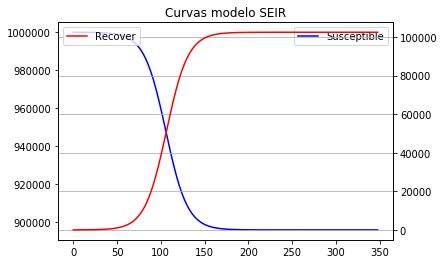

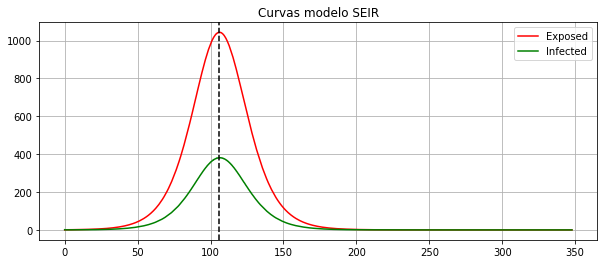

In [19]:
fig,ax1 = plt.subplots()

S = sol_gt.y[0]
E = sol_gt.y[1]
I = sol_gt.y[2]
R = sol_gt.y[3]
D = sol_gt.y[4]
time = sol_gt.t

#fig = plt.figure(figsize=(10,4))
ax1.plot(sol_gt.t,sol_gt.y[0],"b-") #S
ax1.tick_params(axis='y')
ax1.legend(["Susceptible"])
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(sol_gt.t,sol_gt.y[3],"r-") #R
ax2.legend(["Recover"])
plt.title("Curvas modelo SEIR")
plt.grid()
plt.show()

fig = plt.figure(figsize=(10,4))
plt.plot(sol_gt.t,sol_gt.y[1],"r-") #E
plt.plot(sol_gt.t,sol_gt.y[2],"g-") #I
plt.axvline(x=106, color='k', linestyle='--')
plt.legend(["Exposed","Infected"])
plt.title("Curvas modelo SEIR")
plt.grid()

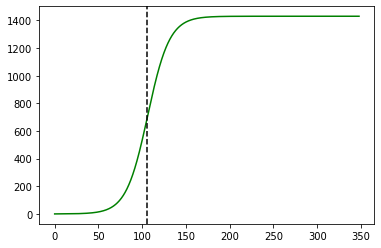

In [20]:
plt.plot(time, D,"g-")
plt.axvline(x=106, color='k', linestyle='--')

[5.803451742467917, 5.496474184702221, 2.007006533343117, 0.07567363348383388]


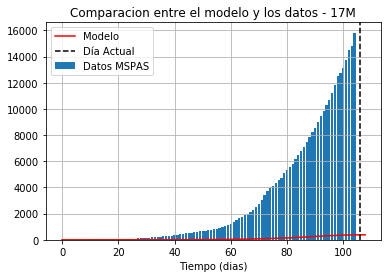

In [21]:
beta,gamma,delta, mu = msol_gt.x #cargando los nuevos parametros
params = [beta,gamma,delta, mu]
print(params)

t_f = 110 #set de tiempo en dias
t_i = 0
sol_gt = solve_ivp(SEIRD,[t_i,t_f],init,args=(N_gt,params),t_eval=np.arange(t_i,t_f-2,0.2))

S = sol_gt.y[0]
E = sol_gt.y[1]
I = sol_gt.y[2]
R = sol_gt.y[3]
D = sol_gt.y[4]
time = sol_gt.t

size = np.arange(0,len(datos_gt_reales),1)
size2 = np.arange(0,len(datos_gt),1)

plt.bar(size,datos_gt_reales) #R
plt.plot(sol_gt.t,sol_gt.y[2],"r-") #I
plt.title("Comparacion entre el modelo y los datos - 17M")
plt.xlabel('Tiempo (dias)')
plt.axvline(x=106, color='k', linestyle='--')
plt.legend(["Modelo","Día Actual","Datos MSPAS"])
plt.grid()

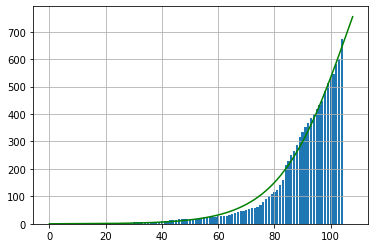

In [22]:
size_d = np.arange(0,len(datos_gt_fallecidos),1)
plt.plot(time, D,"g-")
plt.bar(size_d,datos_gt_fallecidos)
plt.grid()